In [1]:
%matplotlib inline
from pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from treatment_sims_2023_02_21 import *

Splikes version  0.1.2
Plasticnet version  0.1.9
macOS-10.16-x86_64-i386-64bit


In [3]:
from plotutils import *

In [4]:
base='sims/2023-04-05'
if not os.path.exists(base):
    print(f"mkdir {base}")
    os.mkdir(base)
    
old_base='sims/2023-03-01'
    

In [8]:
def addseq(seq,ortho=True):

    base_image_file='asdf/bbsk081604_all.asdf'

    images=[]
    dt=200*ms

    for bv in [blur_left,blur_right]:
        if bv<=0:
            im=pi5.filtered_images(
                                base_image_file,
                                {'type':'dog','sd1':1,'sd2':3},
                                {'type':'norm'},
                                )
        else:
            im=pi5.filtered_images(
                                    base_image_file,
                                    {'type':'blur','size':bv},
                                    {'type':'dog','sd1':1,'sd2':3},
                                    {'type':'norm'},
                                    )
        images.append(im)


    dt=200*ms        
    pre1=pn.neurons.natural_images_with_jitter(images[0],
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=1,
                                                sigma_c=1,
                                                verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(images[1],
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)



    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post,orthogonalization=ortho)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=dt

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)
    sim+=pn.grating_response(print_time=False)


    seq+=sim,[pre,post],[c]
    

## I'm thinking that contrast does nothing to this

- the implementation has the contrast applied to the responses after all the retinal processing
- what should really happen? should the retinal processing just take out the contrast completely?

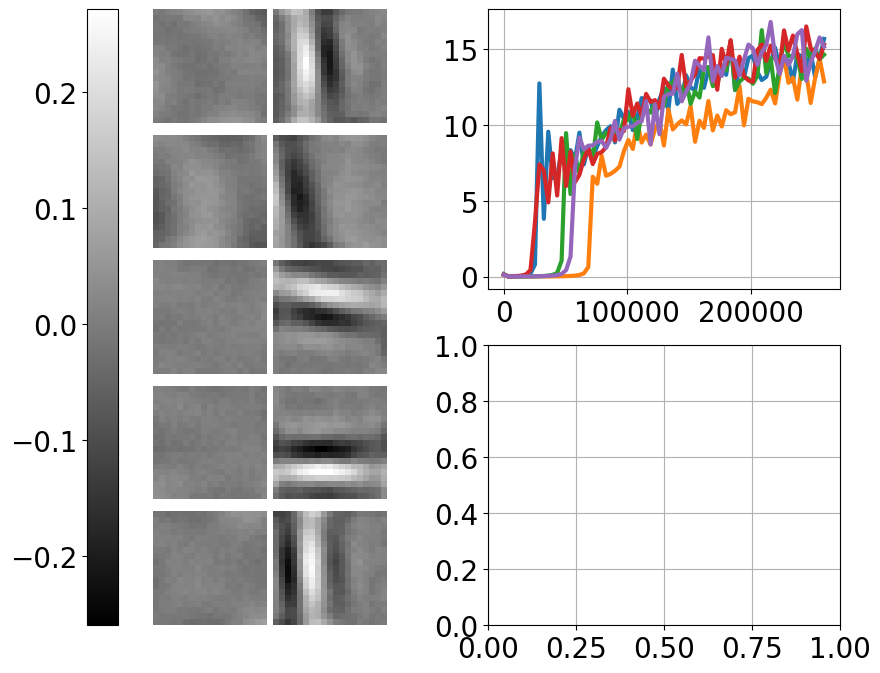

.] Sequence Time Elapsed...1 m, 1.88 s


In [9]:
rf_size=19
eta=2e-6
blur_left=6
blur_right=-1

number_of_neurons=5
number_of_processes=4
mu_c=7.5
sigma_c=2
mu_r=0
sigma_r=0
noise=0.1

seq=pn.Sequence()

total_time=3*day
save_interval=1*hour


addseq(seq,ortho=False)


# blur_left=-1
# blur_right=6

# addseq(seq)
seq.run(display=mydisplay,display_hash=False,
               time_between_display=save_interval)
sfname=f"{base}/blah_deficit_noortho.asdf"
pn.save(sfname,seq) 

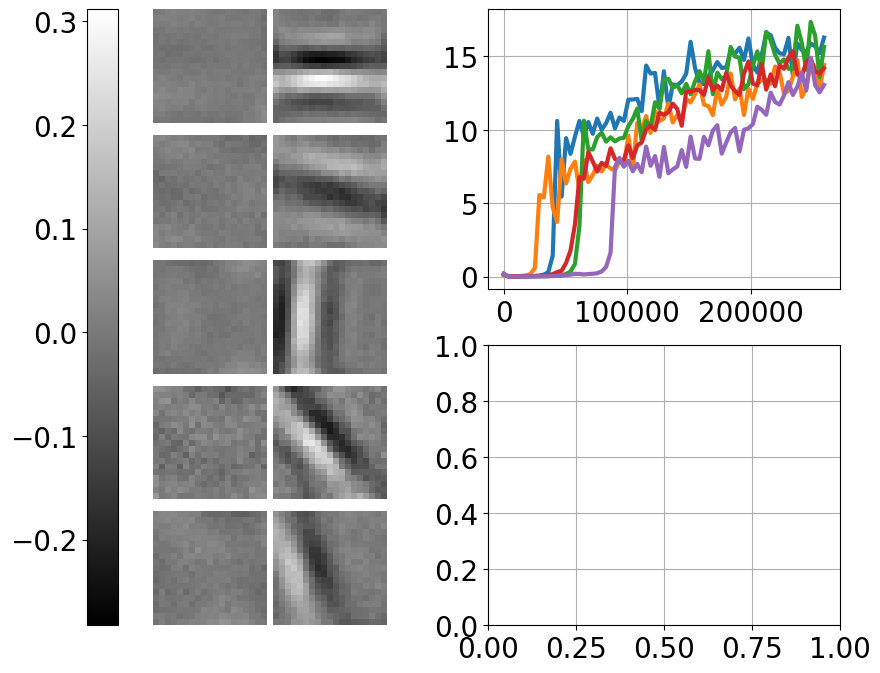

.] Sequence Time Elapsed...59.02 s


In [10]:
rf_size=19
eta=2e-6
blur_left=6
blur_right=-1

number_of_neurons=5
number_of_processes=4
mu_c=7.5
sigma_c=2
mu_r=0
sigma_r=0
noise=0.1

seq=pn.Sequence()

total_time=3*day
save_interval=1*hour


addseq(seq)


# blur_left=-1
# blur_right=6

# addseq(seq)
seq.run(display=mydisplay,display_hash=False,
               time_between_display=save_interval)
sfname=f"{base}/blah_deficit.asdf"
pn.save(sfname,seq) 

In [11]:
def inputs_to_images(X,buffer=5,scale_individually=False):
    ims=[]
    vmin=X.min()
    vmax=X.max()
    
    rf_size=int(np.sqrt(X.shape[1]/2))
    
    for xx in X:
        xx1=xx[:rf_size*rf_size].reshape(rf_size,rf_size)
        xx2=xx[rf_size*rf_size:].reshape(rf_size,rf_size)
        if scale_individually:
            vmax=max([xx1.max(),xx2.max()])
            vmin=min([xx1.min(),xx2.min()])            

            
        im=np.concatenate((xx1,np.ones((rf_size,buffer))*vmax,xx2),axis=1)   
        ims.append(im)
        
    return ims


In [12]:
seq2=pn.Sequence()

total_time=3*day
save_interval=1*hour

#seq2.load_seq(seq)


seq2+=treatment_jitter(
            contrast=0.5,
            noise=noise,noise2=noise,
            rf_size=rf_size,eta=eta,
            f=30,  # size of the blur for mask, which is a measure of overlap
            mu_c=mu_c,sigma_c=sigma_c,    
            mu_r=mu_r,sigma_r=sigma_r,
            number_of_neurons=number_of_neurons,
            total_time=3*day,
            save_interval=1*hour,
            mask=None,
            blur=0)


N_patches=24


pre=seq2[0][1][0]

sim=pn.simulation(N_patches)
sim.monitor(pre,['output'],1)
pn.run_sim(sim,[pre],[],display_hash=False,print_time=False)
m=sim.monitors['output']
t,X=m.arrays()

# first one is not real -- called at the beginning of the sim
t=t[1:]
X=X[1:,:]

/Users/bblais/tmp/ipykernel_25522/3298575462.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar()


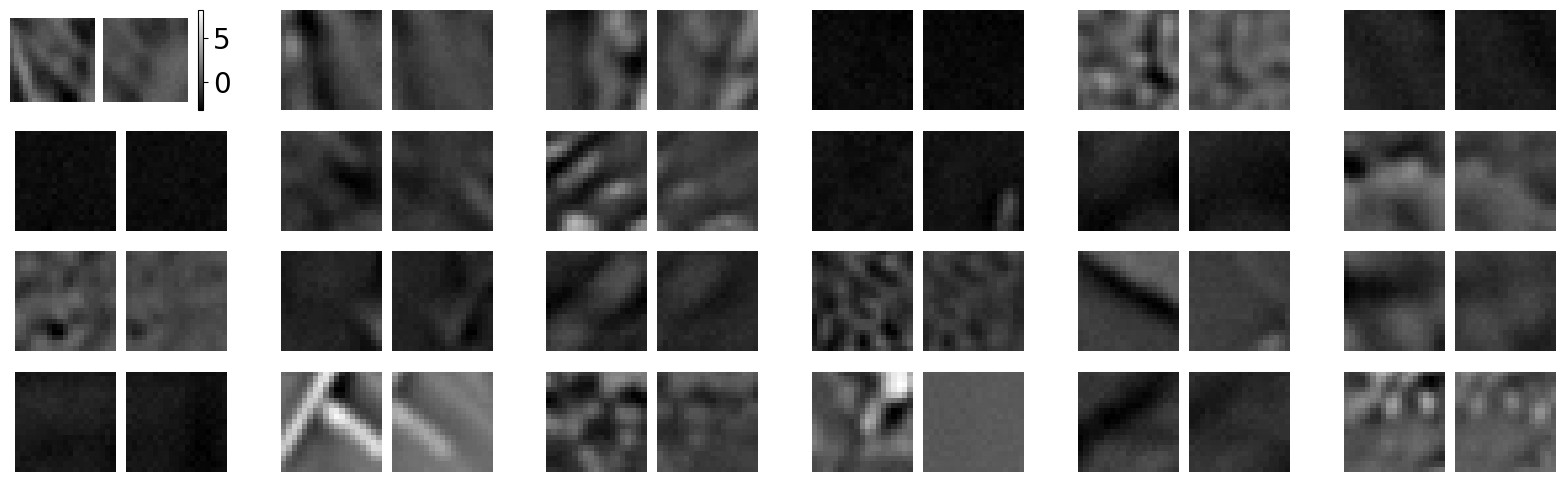

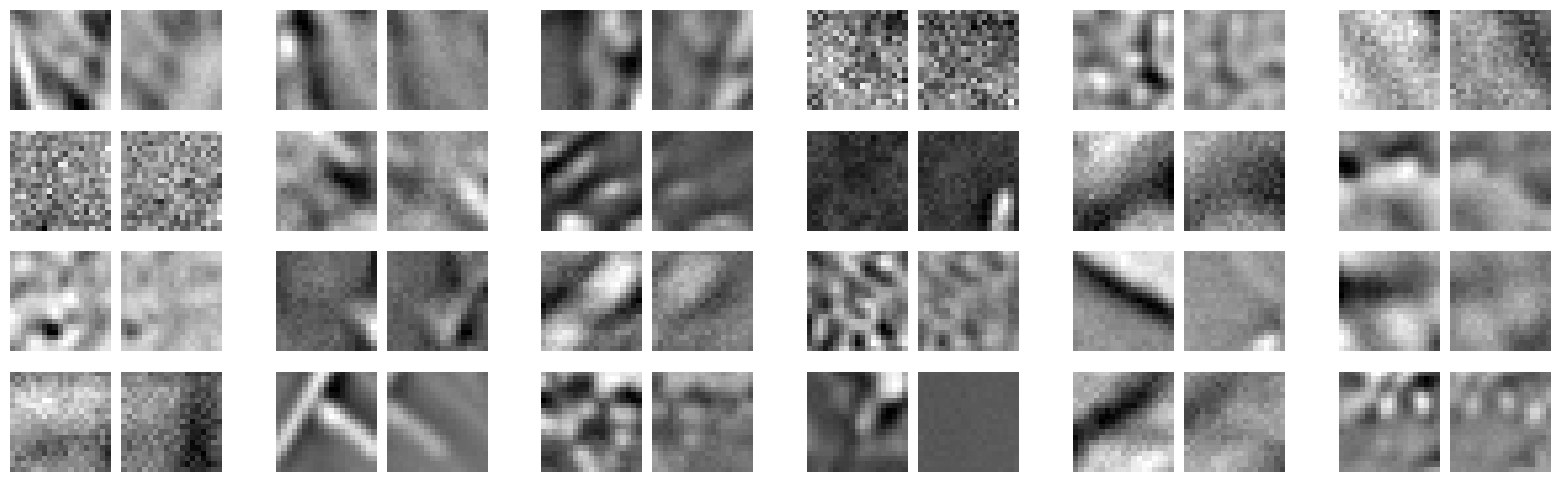

In [13]:
ims=inputs_to_images(X,buffer=2)

Nx=min(N_patches,24)
figure(figsize=(20,6))
for i in range(Nx):
    im=ims[i]
    subplot(4,6,i+1)
    imshow(im,cmap=plt.cm.gray)
    axis('off')
    if i==0:
        colorbar()
    
ims=inputs_to_images(X,buffer=2,scale_individually=True)
figure(figsize=(20,6))
for i in range(Nx):
    im=ims[i]
    subplot(4,6,i+1)
    imshow(im,cmap=plt.cm.gray)
    axis('off')
    


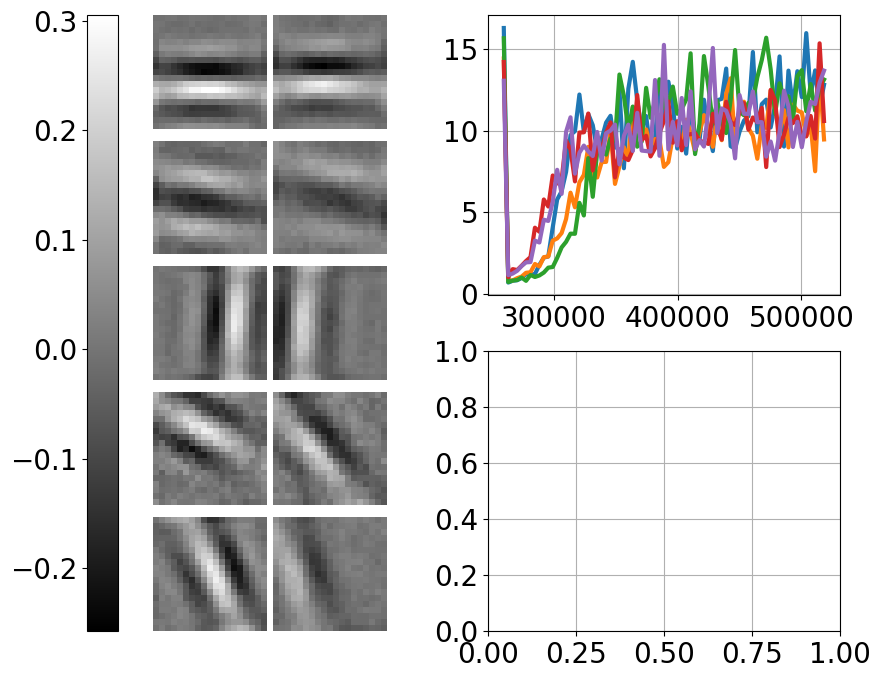

.] Sequence Time Elapsed...53.24 s


In [14]:
seq2=pn.Sequence()

total_time=3*day
save_interval=1*hour

seq2.load_seq(seq)


seq2+=treatment_jitter(
            contrast=0.1,
            noise=noise,noise2=noise,
            rf_size=rf_size,eta=eta,
            f=30,  # size of the blur for mask, which is a measure of overlap
            mu_c=mu_c,sigma_c=sigma_c,    
            mu_r=mu_r,sigma_r=sigma_r,
            number_of_neurons=number_of_neurons,
            total_time=3*day,
            save_interval=1*hour,
            mask=None,
            blur=0)


seq2.run(display=mydisplay,display_hash=False,
               time_between_display=save_interval)
sfname=f"{base}/blah.asdf"
pn.save(sfname,seq2) 

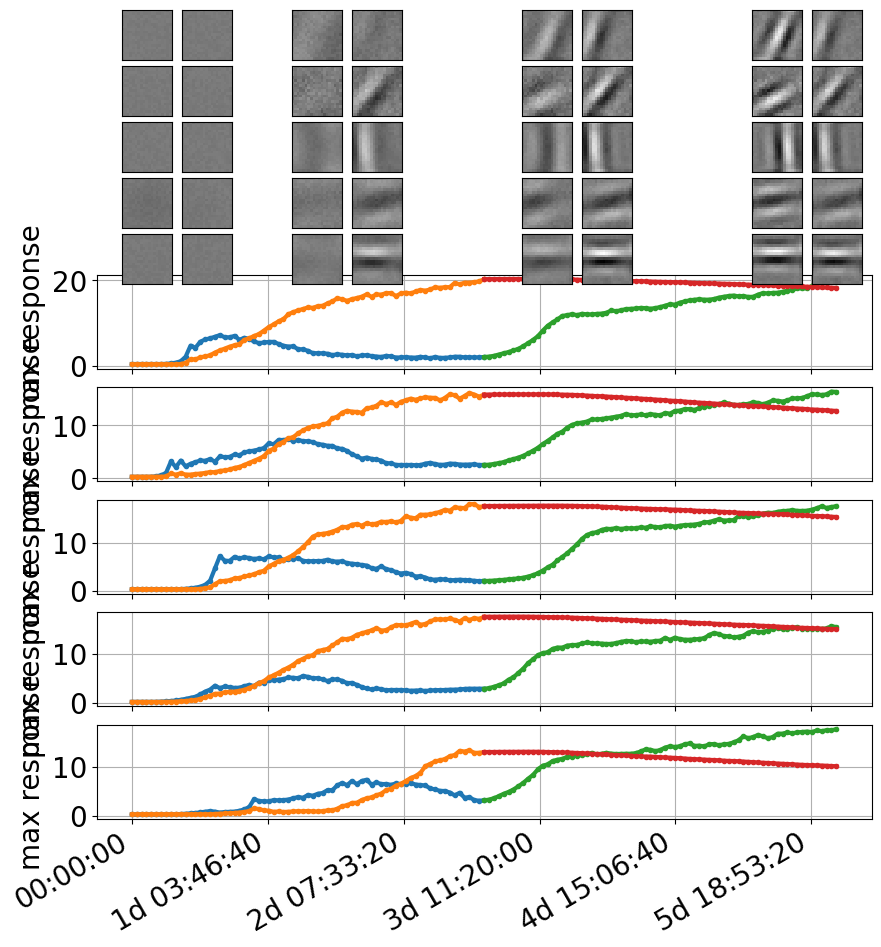

In [15]:
plot_max_response(sfname)
plot_mini_rfs(sfname,
              total_time/10,.15,.85,
              2*total_time/3,.32,.85,
              2*2*total_time/3,.55,.85,
              2*3*total_time/3,.78,.85,
             )

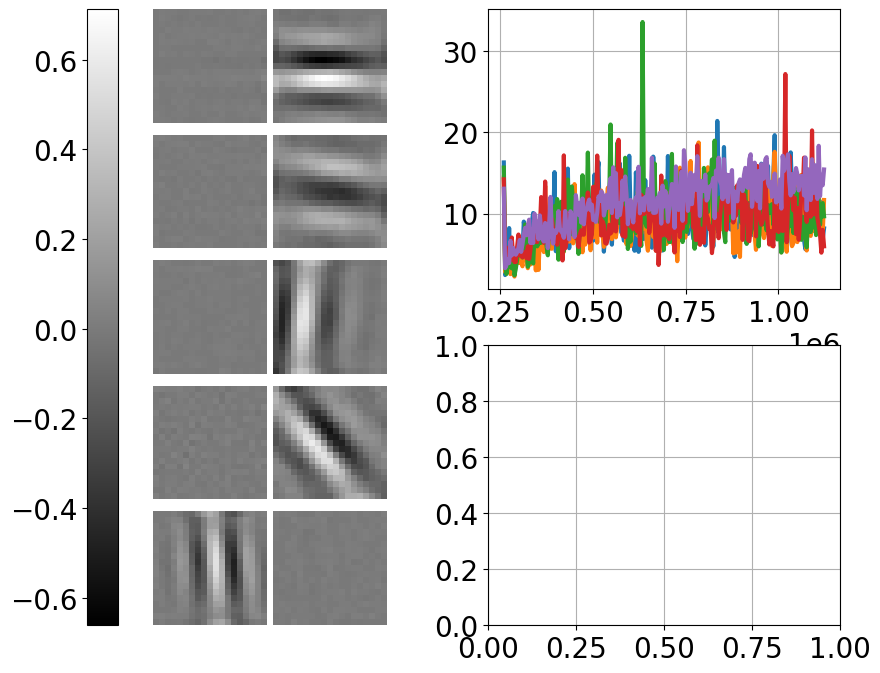

.] Sequence Time Elapsed...2 m, 57.32 s


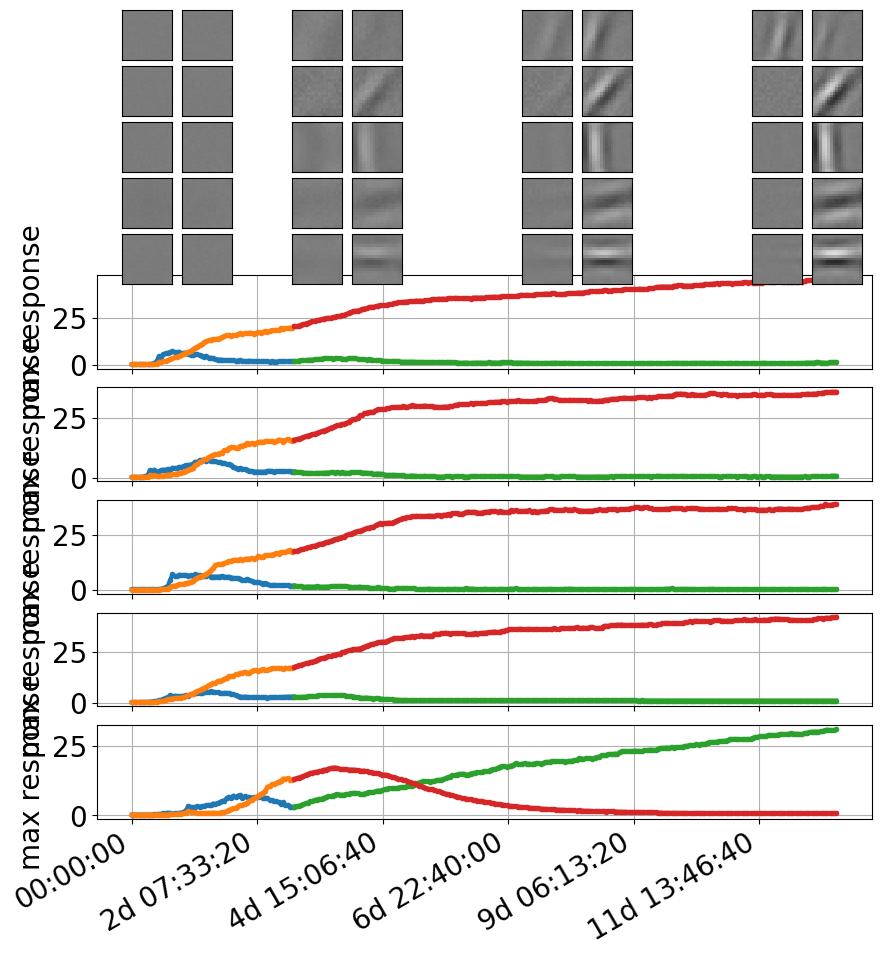

In [16]:
seq2=pn.Sequence()

total_time=3*day
save_interval=1*hour

seq2.load_seq(seq)


seq2+=treatment_jitter(
            contrast=0.4,
            noise=noise,noise2=noise,
            rf_size=rf_size,
            eta=eta,
            f=30,  # size of the blur for mask, which is a measure of overlap
            mu_c=mu_c,sigma_c=sigma_c,    
            mu_r=mu_r,sigma_r=sigma_r,
            number_of_neurons=number_of_neurons,
            total_time=10*day,
            save_interval=1*hour,
            mask=None,
            blur=0)


seq2.run(display=mydisplay,display_hash=False,
               time_between_display=save_interval)
sfname=f"{base}/blah.asdf"
pn.save(sfname,seq2) 


plot_max_response(sfname)
plot_mini_rfs(sfname,
              total_time/10,.15,.85,
              2*total_time/3,.32,.85,
              2*2*total_time/3,.55,.85,
              2*3*total_time/3,.78,.85,
             )

## low contrast with mask

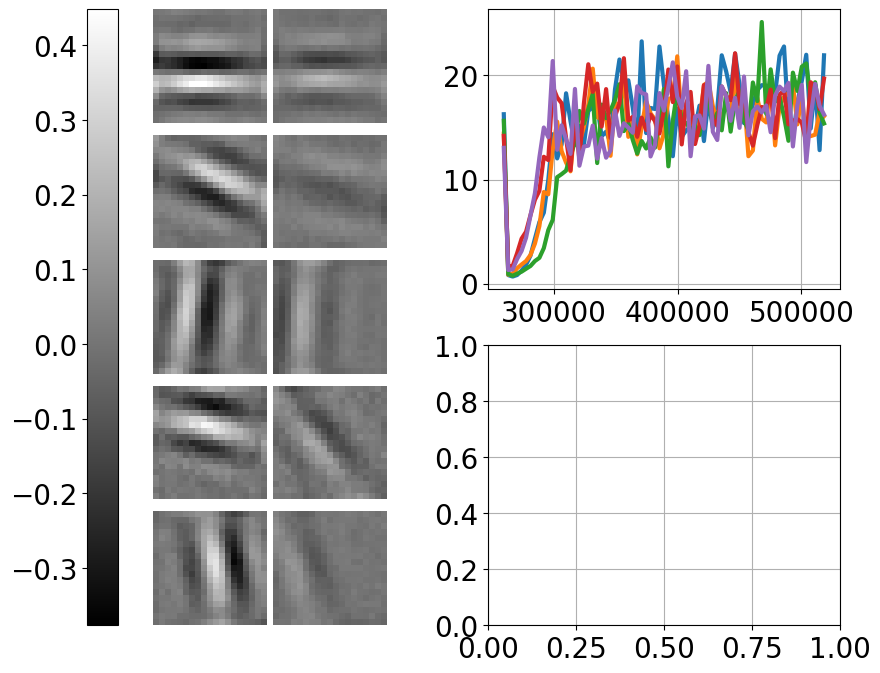

.] Sequence Time Elapsed...58.93 s


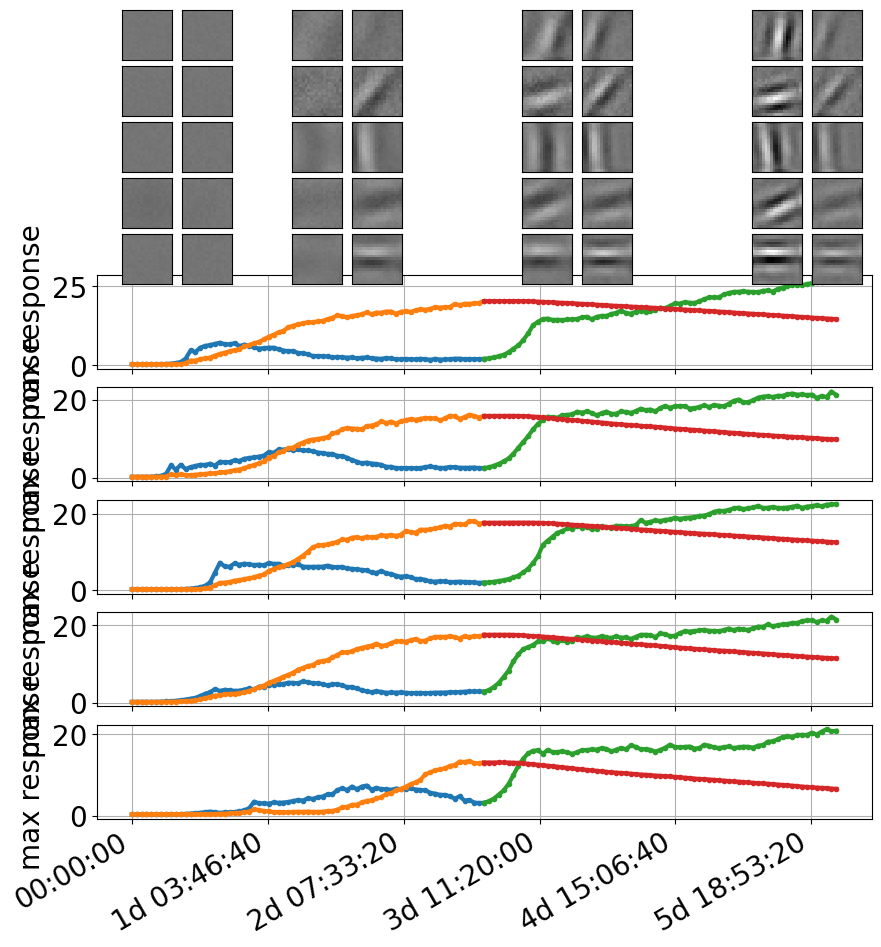

In [17]:
seq2=pn.Sequence()

total_time=3*day
save_interval=1*hour

seq2.load_seq(seq)


seq2+=treatment_jitter(
            contrast=0.1,
            noise=noise,noise2=noise,
            rf_size=rf_size,eta=eta,
            f=30,  # size of the blur for mask, which is a measure of overlap
            mu_c=mu_c,sigma_c=sigma_c,    
            mu_r=mu_r,sigma_r=sigma_r,
            number_of_neurons=number_of_neurons,
            total_time=3*day,
            save_interval=1*hour,
            mask=True,
            blur=0)


seq2.run(display=mydisplay,display_hash=False,
               time_between_display=save_interval)
sfname=f"{base}/blah.asdf"
pn.save(sfname,seq2) 


plot_max_response(sfname)
plot_mini_rfs(sfname,
              total_time/10,.15,.85,
              2*total_time/3,.32,.85,
              2*2*total_time/3,.55,.85,
              2*3*total_time/3,.78,.85,
             )

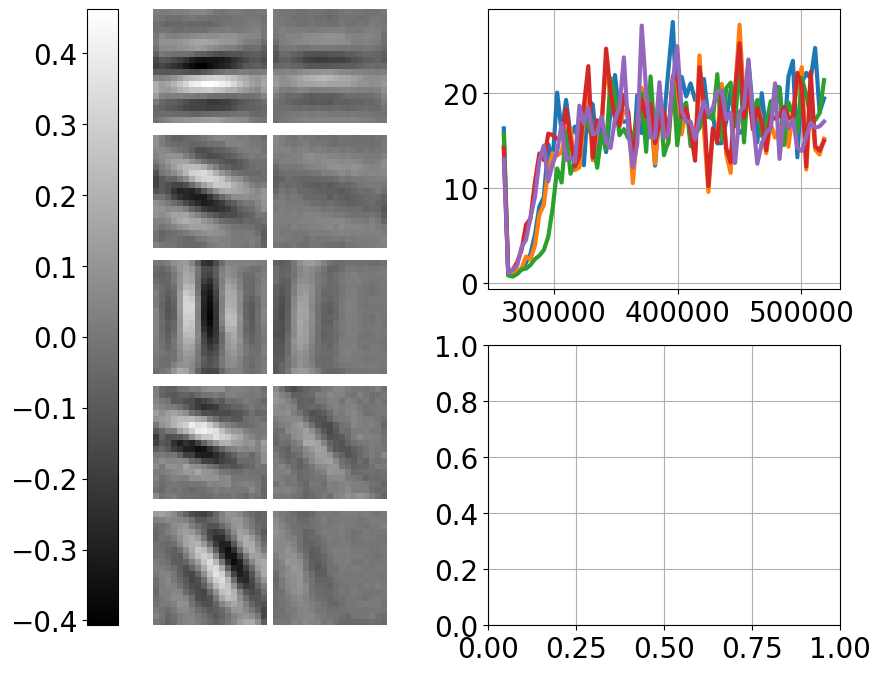

.] Sequence Time Elapsed...59.46 s


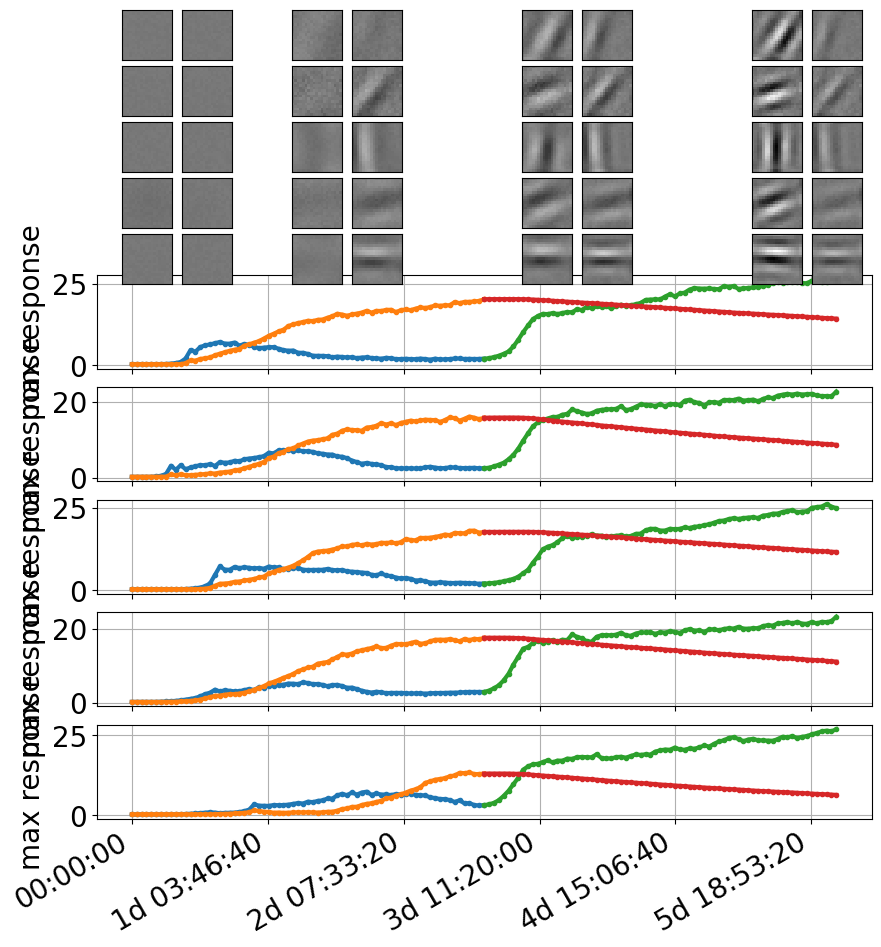

In [18]:
seq2=pn.Sequence()

total_time=3*day
save_interval=1*hour

seq2.load_seq(seq)


seq2+=treatment_jitter(
            contrast=0.1,
            noise=noise,noise2=noise,
            rf_size=rf_size,eta=eta,
            f=10,  # size of the blur for mask, which is a measure of overlap
            mu_c=mu_c,sigma_c=sigma_c,    
            mu_r=mu_r,sigma_r=sigma_r,
            number_of_neurons=number_of_neurons,
            total_time=3*day,
            save_interval=1*hour,
            mask=True,
            blur=0)


seq2.run(display=mydisplay,display_hash=False,
               time_between_display=save_interval)
sfname=f"{base}/blah.asdf"
pn.save(sfname,seq2) 


plot_max_response(sfname)
plot_mini_rfs(sfname,
              total_time/10,.15,.85,
              2*total_time/3,.32,.85,
              2*2*total_time/3,.55,.85,
              2*3*total_time/3,.78,.85,
             )

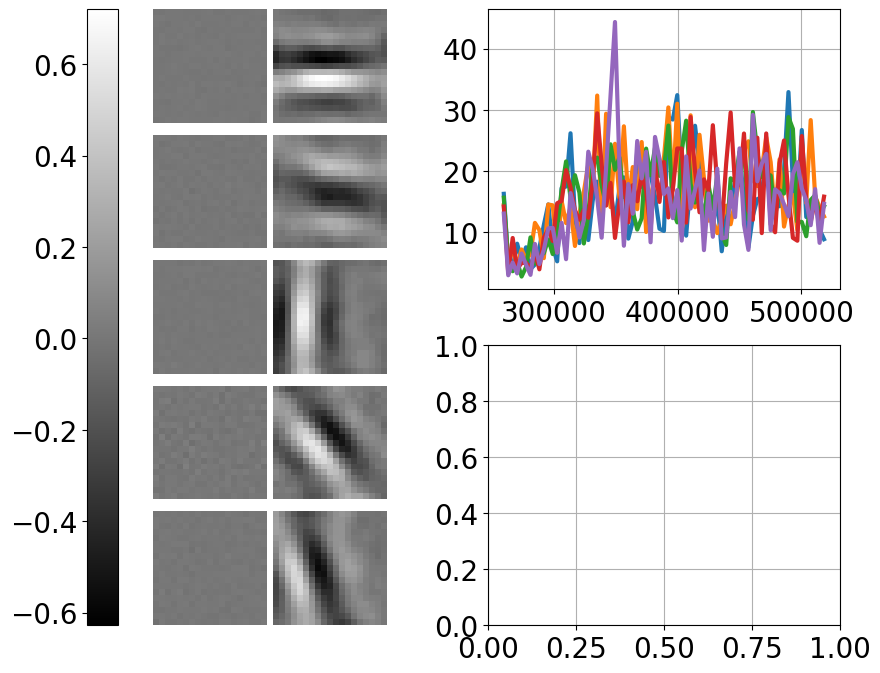

.] Sequence Time Elapsed...59.18 s


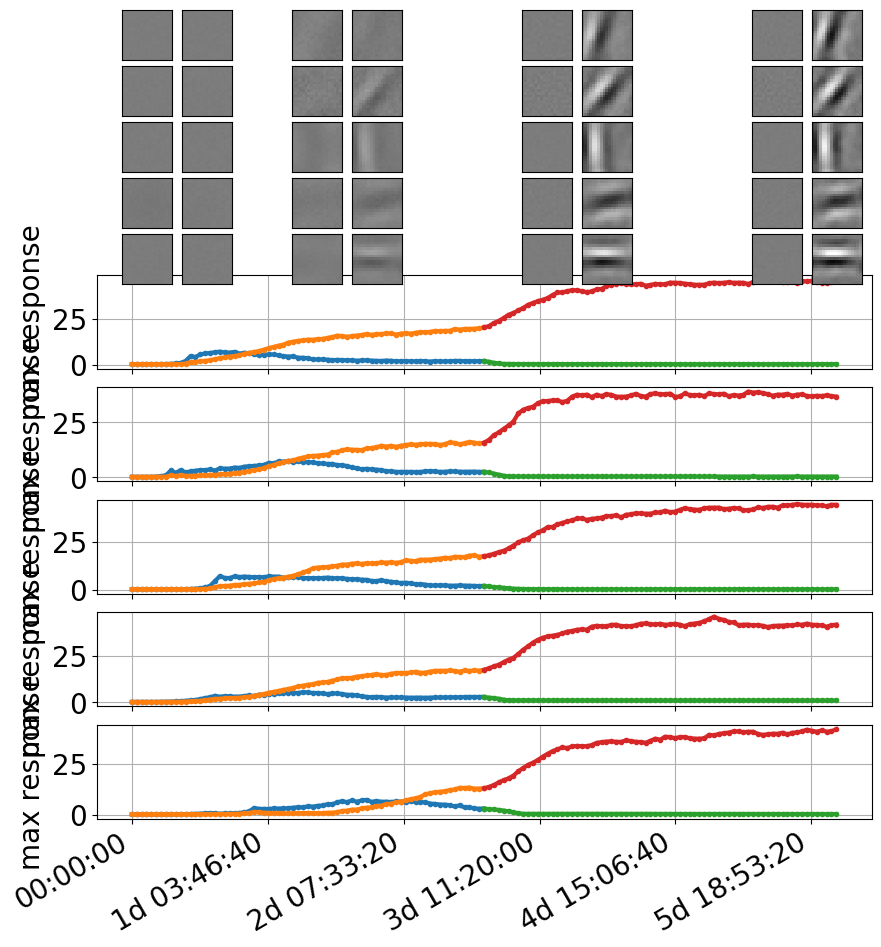

In [19]:
seq2=pn.Sequence()

total_time=3*day
save_interval=1*hour

seq2.load_seq(seq)


seq2+=treatment_jitter(
            contrast=0.5,
            noise=noise,noise2=noise,
            rf_size=rf_size,eta=eta,
            f=10,  # size of the blur for mask, which is a measure of overlap
            mu_c=mu_c,sigma_c=sigma_c,    
            mu_r=mu_r,sigma_r=sigma_r,
            number_of_neurons=number_of_neurons,
            total_time=3*day,
            save_interval=1*hour,
            mask=True,
            blur=0)


seq2.run(display=mydisplay,display_hash=False,
               time_between_display=save_interval)
sfname=f"{base}/blah.asdf"
pn.save(sfname,seq2) 


plot_max_response(sfname)
plot_mini_rfs(sfname,
              total_time/10,.15,.85,
              2*total_time/3,.32,.85,
              2*2*total_time/3,.55,.85,
              2*3*total_time/3,.78,.85,
             )